In [4]:
import math
import pandas as pd
from scipy.optimize import minimize_scalar
#data
L= 0.3 # module length in meters
n_f = 6 #number of fibers
i_d = 1.27e-3#internal diameter m
p_s = 0.1e-6 #pore size in meters
T = 298 #K
gamma_w = 32400#shear rate s-1
gamma_w_list = range(10000,90000,100)
phi_m = 0.68
eta_0 = 0.000905#Pa.second viscosity of hte TGM
rho_p = 1300 #kg/m3 density of the particles
rho_f = 1000 #kg/m3 density of the fluid
k_B = 1.38064852e-23 #J/mol/K Boltzmann constant
phi_w_guess = [0.64,0.64,0.64] #guess for the volume fraction of solute at the membrane wall
# Particle sizes (in meters)
particles = [
    {'name': '10nm', 'radius': 10e-9, 'phi_b': 0.01},
    {'name': '180nm', 'radius': 180e-9, 'phi_b': 0.05},
    {'name': '300nm', 'radius': 300e-9, 'phi_b': 0.06}
]
phi_w_dict={key:values for key, values in zip([particle['radius'] for particle in particles], phi_w_guess)}
target_species = 10e-9 
#equations
#Step 2 - evaluate the viscosity
    # no particle-particle interactions - dillute suspensions
def viscosity_no_PP(eta_0,phi_b,k1):
    """eta_0 - viscosity of the dispersion medium
    phi - volume in parts occupied by the dispersed solid
    k1 = shape factor"""
    eta_phi = eta_0*(1+5/2*phi_b+k1*phi_b**2)
    return eta_phi
eta_f = viscosity_no_PP(eta_0,sum(particles['phi_b'] for particles in particles),10)

# eta_f = 0.001307
diffusion_coeff = (k_B * T) / (6 * math.pi * eta_f * target_species)


#k1 around 10 for spheres
#not sure about the shape factor

def max_agg_packing (phi_m):
    phi_Max=phi_m+0.74*(1-phi_m)
    return phi_Max
phi_M = max_agg_packing(phi_m)
# phi_M = 0.92

#step 3 - maximum back-transport velocity, u (m/s)- Brownian, shear-infuced and intertial lift - Full retention of all solutes
 #particle volume franction at the membrane wall for each particle size for the first iteration
#J_flux = 30 #LMH


def J_brownian(a, phi_w, phi_b):
    numerator = gamma_w * (k_B ** 2) * (T ** 2)
    denominator = (eta_f ** 2) * (a ** 2) * L
    term = (numerator / denominator) ** (1/3)
    J = 0.114 * term * math.log(phi_w / phi_b)
    return J

# Function to calculate J for shear-induced diffusion
def J_shear(a, phi_w, phi_b):
    term = (a ** 4 / L) ** (1/3)
    log_term = math.log(phi_w / phi_b)
    J = 0.078 * term * gamma_w * abs(log_term)
    return J

# Function to calculate J for inertial lift
def J_inertial(a):
    J = (0.036 * rho_p * (a ** 3) * (gamma_w ** 2)) / eta_f
    return J
#J solvent permeation flux (m/s)


set_data = pd.DataFrame(columns=['name', 'radius', 'max_velocity', 'source'])
velocities_list=[]
def min_flux(Particles, phi_w_list):
    """ have to put particles list with radius and phi_b,
    phi_w_list with phi_w
    results ai_target, J_flux and dataframe"""
    
    min_velocity = float('inf')
    selected_particle_radius = None
    

    for particle, phi_w in zip(Particles, phi_w_list):
        a = particle['radius']
        phi_b = particle['phi_b']
        
        # Calculate velocities
        brownian_velocity = J_brownian(a, phi_w, phi_b)
        shear_velocity = J_shear(a, phi_w, phi_b)
        inertial_velocity = J_inertial(a)
        
        # Find the maximum velocity
        max_velocity = max(brownian_velocity, inertial_velocity, shear_velocity)
        
        # Determine the source of the maximum velocity
        source = 'brownian' if max_velocity == brownian_velocity else 'inertial' if max_velocity == inertial_velocity else 'shear'
        
        # Update set_data by replacing previous row or adding a new one
        if particle['name'] in set_data['name'].values:
            set_data.loc[set_data['name'] == particle['name'], ['radius', 'max_velocity', 'source']] = [a, max_velocity, source]
        else:
            set_data.loc[len(set_data)] = [particle['name'], a, max_velocity, source]
        # Store all velocities in the DataFrame
        velocities_list.append({
            'name': particle['name'],
            'radius': a,
            'brownian_velocity': brownian_velocity,
            'shear_velocity': shear_velocity,
            'inertial_velocity': inertial_velocity
        })
        velocities_df=pd.DataFrame(velocities_list)
        # print(velocities_df)
        # Check for the minimum velocity
        if max_velocity < min_velocity:
            min_velocity = max_velocity
            selected_particle_radius = a

    return selected_particle_radius, min_velocity, set_data,velocities_df

# Initialize variables for particles and inertial-lift properties
# ai_target, min_vel, dataf= min_flux(particles, phi_w_guess)

# Function to calculate φ_w for each particle size
def calculate_phi_w(Particles, a_target, min_velocity, data):
    count = 0
    # Dictionaries to store results
    phi_w_J_dict = {}
    phi_wjI_dict = {}
    inertial_particles = []
    
    for particle in Particles:
        a_particle = particle['radius']
        phi_b_particle = particle['phi_b']
        
        if a_particle != a_target:
            # Retrieve the velocity source from the data DataFrame
            source = data.loc[data['radius'] == a_particle, 'source'].values[0]
            max_velocity = data.loc[data['radius'] == a_particle, 'max_velocity'].values[0]
            if max_velocity >= 10 * min_velocity:
                # Handle inertial particles
                phi_wjI = 0
                phi_wjI_dict[a_particle] = phi_wjI
                phi_w_dict[a_particle] = phi_wjI
                phi_w_J_dict[a_particle] = phi_wjI
                inertial_particles.append((a_particle, phi_b_particle, max_velocity))
            if source =="inertial":
                count += 1   
            else:
                # Define the objective function based on the source
                def objective_function(phi_w_particle):
                    # Recalculate velocities based on the current wall concentration phi_w_particle
                    max_velocity = max(J_brownian(a_particle, phi_w_particle, phi_b_particle),J_shear(a_particle, phi_w_particle, phi_b_particle))
    
                    return abs(max_velocity - min_velocity)

                # Minimize the objective function to find the optimal phi_w for the particle
                result = minimize_scalar(objective_function, bounds=(0, 0.64), method='bounded')

                if result.success:
                    phi_w_optimal = result.x
                    phi_w_dict[a_particle] = phi_w_optimal
                    phi_w_J_dict[a_particle] = phi_w_optimal
                else:
                    print(f"Optimization failed for particle radius {a_particle:.1e} m")
    
    # Handle inertial particles after processing all particles
    if count == 1:
        for a, phi_b, u_j in inertial_particles:
            phi_wjI = phi_M - sum(phi_w_J_dict.values())
            phi_wjI_dict[a] = phi_wjI
            phi_w_dict[a] = phi_wjI
    elif count > 1:
        total_u_j_inv = sum((phi_b / u_j) for _, phi_b, u_j in inertial_particles)
        phi_w_remaining = phi_M - sum(phi_w_J_dict.values())
        phi_w_jI_sum = sum((phi_b / u_j) / total_u_j_inv * phi_w_remaining for _, phi_b, u_j in inertial_particles)
        if abs(phi_M - (sum(phi_w_J_dict.values()) + phi_w_jI_sum)) > 1e-6:
            print("Warning: φ_M and the sum of φ_w_j do not match closely enough.")
        
        for a, phi_b, u_j in inertial_particles:
            phi_wjI = (phi_b / u_j) / total_u_j_inv * phi_w_remaining
            phi_wjI_dict[a] = phi_wjI
            phi_w_dict[a] = phi_wjI

    return phi_w_dict


# Output the updated dictionary
#print(f"Updated phi_w_dict: {phi_w_dict}")
target_dict = {}
def packing_constraints(Particles, phi_w_list):
    ai_target, min_vel, dataf,vel= min_flux(Particles, phi_w_list)
    phi_w_updated=calculate_phi_w(Particles, ai_target, min_vel, dataf)
    
    tolerance = 1e-6  # Set a tolerance for convergence
    max_iterations = 1000


    for i in range(max_iterations):
        remaining_phiw_j = {a: phi_w for a, phi_w in phi_w_updated.items() if a != min(phi_w_updated.keys())}
        phi_w_i = phi_w_updated[ai_target] # Wall concentration of the target particle
        # Check if packing constraints are satisfied
        if (phi_M >= sum(phi_w_updated.values())) and (sum(remaining_phiw_j.values()) <= 0.68) and phi_w_updated[min(phi_w_updated.keys())] <= 0.74 * (1 - sum(remaining_phiw_j.values())) and phi_smallest_int<0.74:
            print(f"Iteration {i}: Packing constraints are met.")
            return phi_w_updated,   min_vel, ai_target, dataf,r_minimum, phi_smallest_int
        
        # Store the previous values of phi_w for comparison
        phi_w_previous = phi_w_updated.copy()
        # Update phi_w for the target particle
        phi_w_i_corrected = phi_M * (phi_w_i / sum(phi_w_updated.values()))
        phi_w_updated[ai_target] = phi_w_i_corrected
        phi_w_updated_list = list(phi_w_updated.values())
        #print(phi_w_updated, J_flux, a_target)
        # Recalculate the flux and phi_w_j values after updating
        ai_target, min_vel, dataf,vel= min_flux(particles, phi_w_updated_list)
        phi_w_updated=calculate_phi_w(particles, ai_target, min_vel, dataf)
        phi_smallest_int= phi_w_dict[min(phi_w_dict.keys())] / (1 -sum(phi_w for phi_w in phi_w_dict.values() if phi_w != phi_w_dict[min(phi_w_dict.keys())]))
#        
#       # #step - 9 - calculate the minimum
        r_minimum = (min(phi_w_dict.keys()) * ( (math.sqrt(2) * ((( 4 * (4 / 3) * math.pi ) / phi_smallest_int )) ** (1/3)) - 2 ))/2
        
        # Check for the change in phi_w values between iterations
        target_dict[ai_target] = min_vel
        phi_w_diff = sum(abs(phi_w_updated[a] - phi_w_previous[a]) for a in phi_w_updated)

        # If the change in phi_w values is smaller than the tolerance, stop the iteration
        if phi_w_diff < tolerance :
            print(f"Iteration {i}: Will not converger further.")
            return phi_w_updated,   min_vel, ai_target, dataf,r_minimum, phi_smallest_int
    # If the loop completes without finding a solution
    print("Warning: No solution found within the iteration limit.")
  
    return phi_w_updated, min_vel, ai_target, dataf,r_minimum, phi_smallest_int

#mass-transfer coefficient calculated from equation  1#step 10


def sieving_parameters(Particles, phi_w_list):
    phi_w_updated, J_flux, ai_target, dataf, r_min, phi_smal_int = packing_constraints(Particles, phi_w_list)
    # print(f"Updated phi_w_dict: {phi_w_updated}. J_flux: {J_flux}")
    S_0=0
    for i in range(20):
        Q = J_flux * n_f * math.pi * i_d * (L + L / 20)
        mass_transfer_k = 1.62 * (diffusion_coeff / i_d) * (((4 * rho_f * Q) / (math.pi * n_f * i_d * eta_f)) ** (1 / 3)) * ((eta_f / (rho_f * diffusion_coeff)) ** (1 / 3))
        print(f"mass transfer coefficient: {mass_transfer_k}")
        lambda_s_min = target_species / r_min
        print(f"lambda_s_min: {lambda_s_min}")
        Sieving_coeff_int = ((1 - lambda_s_min) ** 2) * (2 - ((1 - lambda_s_min) ** 2)) * math.exp(-0.7146 * (lambda_s_min ** 2))
        print(f"Initial Sieving coefficient: {Sieving_coeff_int}")
        delta_m = target_species * ((4 * (4 / 3) * math.pi) / phi_smal_int) ** (1 / 3)
        print(f"delta_m: {delta_m}")
        phi_e_K_d = (1 - lambda_s_min) ** (9 / 2)
        print(f"phi_e_K_d: {phi_e_K_d}")
        cake_membrane_porosity = 1 - phi_smal_int
        print(f"cake_membrane_porosity: {cake_membrane_porosity}")
        Peclet_m = ((J_flux * delta_m) / diffusion_coeff) * (Sieving_coeff_int / (cake_membrane_porosity * phi_e_K_d))
        print(f"Peclet_m: {Peclet_m}")
        if Peclet_m >709:
            Sieving_coeff_act = Sieving_coeff_int
        else:
            Sieving_coeff_act = (Sieving_coeff_int * math.exp(Peclet_m)) / ((Sieving_coeff_int + math.exp(Peclet_m)) - 1)
        # Sieving_coeff_act = (Sieving_coeff_int * math.exp(Peclet_m)) / (Sieving_coeff_int + math.exp(Peclet_m) - 1)
        print(f"Actual Sieving coefficient: {Sieving_coeff_act}")
        Sieving_coeff_obs = Sieving_coeff_act / (((1 - Sieving_coeff_act) * math.exp(-J_flux / mass_transfer_k)) + Sieving_coeff_act)
        print(f"Observed Sieving coefficient: {Sieving_coeff_obs}")
        yields = 1 - math.exp(-4 * (Sieving_coeff_obs))
        print(f"Yields: {yields}")
        # Convergence check for the main loop
        if (abs(S_0-Sieving_coeff_obs)/((Sieving_coeff_obs))) < 0.1:
            print(f"Convergence reached after {i} iterations.")
            print(f"Final Sieving coefficient (obs): {Sieving_coeff_obs}")
            print(f"Final Yield: {yields}")
            print(f"Final flux: {J_flux}")
            for particle in Particles:
                name = particle['name']
                phi_b = particle['phi_b']
                phi_w = phi_w_updated[particle['radius']]
                print(f"Particle {name}:")
                print(f"  Bulk concentration (phi_b): {phi_b}")
                print(f"  Wall concentration (phi_w): {phi_w}")
            return dataf, phi_w_updated,yields
        if  yields>0.75:
            print(f"Final iteration {i}")
            print(f"Final Sieving coefficient (obs): {Sieving_coeff_obs}")
            print(f"Final Yield: {yields}")
            print(f"Final flux: {J_flux}")
            for particle in Particles:
                name = particle['name']
                phi_b = particle['phi_b']
                phi_w = phi_w_updated[particle['radius']]
                print(f"Particle {name}:")
                print(f"  Bulk concentration (phi_b): {phi_b}")
                print(f"  Wall concentration (phi_w): {phi_w}")
            return dataf, phi_w_updated,yields
        if  yields>0.95 and i==0:
            print(f"Final iteration {i}")
            print(f"Final Sieving coefficient (obs): {Sieving_coeff_obs}")
            print(f"Final Yield: {yields}")
            print(f"Final flux: {J_flux}")
            for particle in Particles:
                name = particle['name']
                phi_b = particle['phi_b']
                phi_w = phi_w_updated[particle['radius']]
                print(f"Particle {name}:")
                print(f"  Bulk concentration (phi_b): {phi_b}")
                print(f"  Wall concentration (phi_w): {phi_w}")
            return dataf, phi_w_updated,yields
        if Sieving_coeff_obs<0.75:
        # # # Update flux if sieving coefficient is within a valid range
        #     phi_w_dict[target_species] = (1 - Sieving_coeff_obs)*(Particles[0]['phi_b']*math.exp(J_flux/mass_transfer_k))
        # print(phi_w_dict[target_species])
            Sieving_coeff_obs = 1-(phi_w_dict[target_species]/( math.exp(J_flux/mass_transfer_k)*Particles[0]['phi_b'] ))
            # Sieving_coeff_act = Sieving_coeff_obs/(phi_w_dict[target_species]/Particles[0]['phi_b'] )
            # print(f"Updated Sieving coefficient: {Sieving_coeff_obs}")
            # print(Sieving_coeff_act)
            J_flux = -mass_transfer_k*math.log(abs((Sieving_coeff_act*(1-Sieving_coeff_obs))/(Sieving_coeff_obs*(1-Sieving_coeff_act))) )
            print(J_flux)
        S_0 = Sieving_coeff_obs
        # Sub-loop for calculating phi_w and r_min
        for j in range(30):
            phi_w_updated=calculate_phi_w(Particles, ai_target, J_flux, dataf)
            phi_w_i = phi_w_updated[ai_target] # Wall concentration of the target particle
            # Store the previous values of phi_w for comparison
            phi_w_previous = phi_w_updated.copy()
            # Update phi_w for the target particle
            phi_w_i_corrected = phi_M * (phi_w_i / sum(phi_w_updated.values()))
            # print(phi_w_updated)
            phi_w_updated[ai_target] = phi_w_i_corrected
            ai_target, J_flux, dataf,vel= min_flux(Particles, phi_w_updated.values())
            # print(dataf)
            
            remaining_phiw_j = {a: phi_w for a, phi_w in phi_w_updated.items() if a != min(phi_w_updated.keys())}
            # print(phi_w_updated)
            if (phi_M >= sum(phi_w_updated.values())) and (sum(remaining_phiw_j.values()) <= 0.68) and phi_w_updated[min(phi_w_updated.keys())] <= 0.74 * (1 - sum(remaining_phiw_j.values())) and phi_smal_int<0.74:
                print(f"Iteration {i}: Packing constraints are met.")
                phi_smal_int= phi_w_updated[min(phi_w_updated.keys())] / (1 -sum(phi_w for phi_w in phi_w_updated.values() if phi_w != phi_w_dict[min(phi_w_dict.keys())]))
        #   # #step - 9 - calculate the minimum
                r_min = (min(phi_w_updated.keys()) * ( (math.sqrt(2) * ((( 4 * (4 / 3) * math.pi ) / phi_smal_int )) ** (1/3)) - 2 ))/2
                break

            # Check for the change in phi_w values between iterations

            phi_w_diff = sum(abs(phi_w_updated[a] - phi_w_previous[a]) for a in phi_w_updated)
            
            # If the change in phi_w values is smaller than the tolerance, stop the iteration
            if phi_w_diff < 10e-6:
                phi_smal_int= phi_w_updated[min(phi_w_updated.keys())] / (1 -sum(phi_w for phi_w in phi_w_updated.values() if phi_w != phi_w_dict[min(phi_w_dict.keys())]))
        #   # #step - 9 - calculate the minimum
                r_min = (min(phi_w_updated.keys()) * ( (math.sqrt(2) * ((( 4 * (4 / 3) * math.pi ) / phi_smal_int )) ** (1/3)) - 2 ))/2
            
                print(f"Iteration {i}: Will not converger further.")
                break

    print("Warning: No solution found within the iteration limit.")
    return dataf, phi_w_updated,yields

sieving_parameters(particles, phi_w_guess)


Iteration 1: Packing constraints are met.
mass transfer coefficient: 1.8227468716742183e-06
lambda_s_min: 0.9687120610424401
Initial Sieving coefficient: 0.0010007851705221024
delta_m: 2.874104090474135e-08
phi_e_K_d: 1.6951038114225828e-07
cake_membrane_porosity: 0.2942658676737824
Peclet_m: 286.57237386708044
Actual Sieving coefficient: 0.0010007851705221024
Observed Sieving coefficient: 0.08690128689642021
Yields: 0.2936222638889656
1.4251301964894966e-05
Iteration 0: Packing constraints are met.
mass transfer coefficient: 1.6795516362779912e-06
lambda_s_min: 0.6176027589604194
Initial Sieving coefficient: 0.20639982441630692
delta_m: 3.70405689913793e-08
phi_e_K_d: 0.013222585258149204
cake_membrane_porosity: 0.670302501189425
Peclet_m: 0.3353728576567419
Actual Sieving coefficient: 0.47720384512748504
Observed Sieving coefficient: 0.9775826079554367
Yields: 0.979966119863648
Final iteration 1
Final Sieving coefficient (obs): 0.9775826079554367
Final Yield: 0.979966119863648
Final 

(    name        radius  max_velocity    source
 0   10nm  1.000000e-08      0.000006  brownian
 1  180nm  1.800000e-07      0.000008     shear
 2  300nm  3.000000e-07      0.000006     shear,
 {1e-08: np.float64(0.13259204946230835),
  1.8e-07: np.float64(0.45653593094508055),
  3e-07: np.float64(0.14130132914742613)},
 0.979966119863648)

In [ ]:
data_figs=pd.DataFrame(columns=['shear_rate', 'J_pred_10',"J_pred_180","J_pred_300",'yield', 'phi_w_10', 'phi_w_180', 'phi_w_300'])
gamma_w_list=range(20000,90000,1000)
for i in range(len(gamma_w_list)):
    phi_w_dict={key:values for key, values in zip([particle['radius'] for particle in particles], phi_w_guess)}
    gamma_w = gamma_w_list[i] #shear rate s-1
    print(f"shear rate: {gamma_w}")
    data_F,phi_w_dict,Yield=sieving_parameters(particles, phi_w_guess)
    data_figs.loc[i] = [gamma_w, data_F.loc[0, 'max_velocity']*1000*3600, data_F.loc[1, 'max_velocity']*1000*3600, data_F.loc[2, 'max_velocity']*1000*3600, Yield, phi_w_dict[10e-9], phi_w_dict[180e-9], phi_w_dict[300e-9]]

In [ ]:
1-0.272/(math.exp(0.000008/1.8227468716742183e-06)*0.01)

In [12]:
data_figs.to_csv('/Users/baochikhuc/Documents/microfiltration_model_2024/Model/Data_adjuted_J/data_figs.csv', index=False)

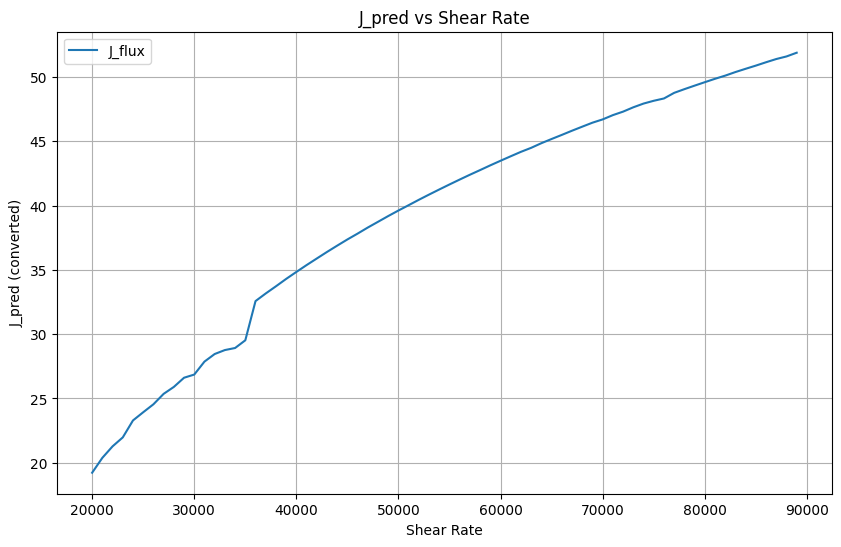

In [4]:


import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))
# plt.plot(data_figs['shear_rate'], data_figs['J_pred_10'], label='J_pred_10')
plt.plot(data_figs['shear_rate'], data_figs[['J_pred_10', 'J_pred_180', 'J_pred_300']].min(axis=1), label='J_flux')
plt.xlabel('Shear Rate')
plt.ylabel('J_pred (converted)')
plt.title('J_pred vs Shear Rate')
plt.legend()
plt.grid(True)
plt.show()


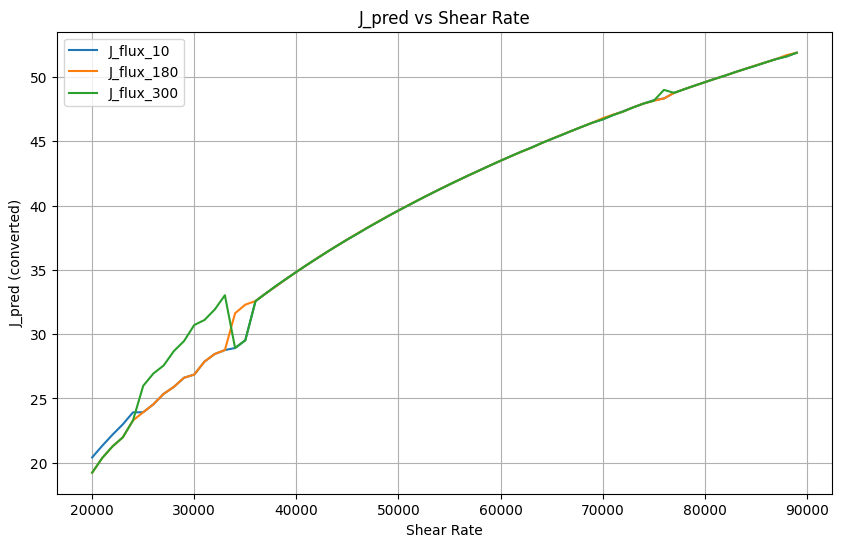

In [6]:
plt.figure(figsize=(10, 6))
# plt.plot(data_figs['shear_rate'], data_figs['J_pred_10'], label='J_pred_10')
plt.plot(data_figs['shear_rate'], data_figs['J_pred_10'], label='J_flux_10')
plt.plot(data_figs['shear_rate'], data_figs['J_pred_180'], label='J_flux_180')
plt.plot(data_figs['shear_rate'], data_figs['J_pred_300'], label='J_flux_300')
plt.xlabel('Shear Rate')
plt.ylabel('J_pred (converted)')
plt.title('J_pred vs Shear Rate')
plt.legend()
plt.grid(True)
plt.show()

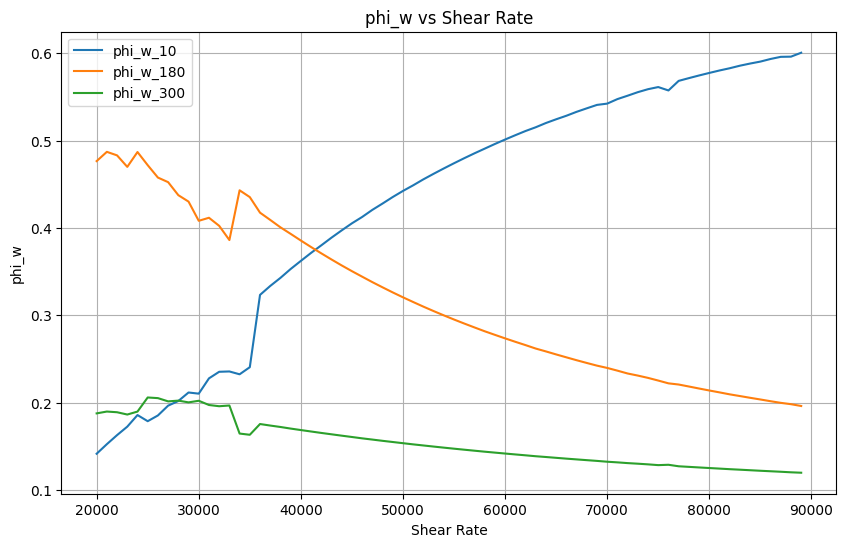

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(data_figs['shear_rate'], data_figs['phi_w_10'], label='phi_w_10')
plt.plot(data_figs['shear_rate'], data_figs['phi_w_180'], label='phi_w_180')
plt.plot(data_figs['shear_rate'], data_figs['phi_w_300'], label='phi_w_300')
plt.xlabel('Shear Rate')
plt.ylabel('phi_w')
plt.title('phi_w vs Shear Rate')
plt.legend()
plt.grid(True)
plt.show()

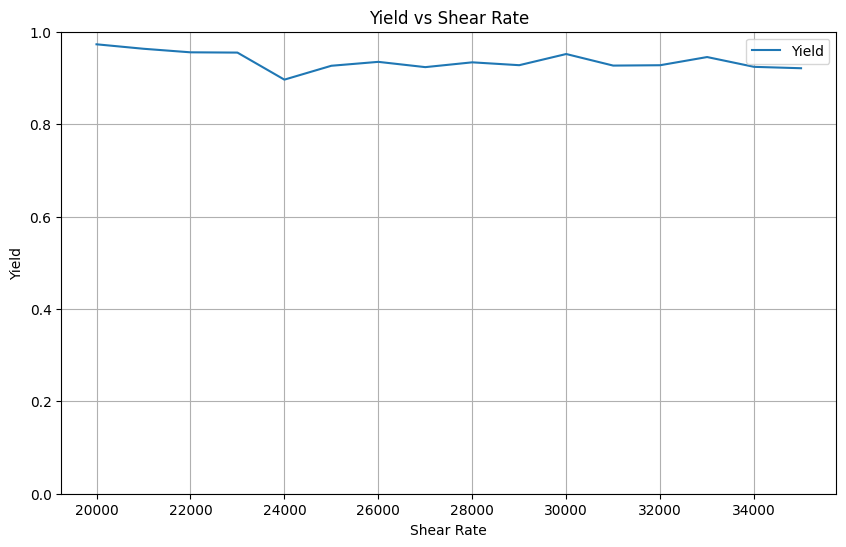

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(data_figs['shear_rate'], data_figs['yield'], label='Yield')
plt.xlabel('Shear Rate')
plt.ylabel('Yield')
plt.title('Yield vs Shear Rate')
plt.legend()
plt.ylim(0,1)
plt.grid(True)
plt.show()

In [ ]:
data_figs_2=pd.DataFrame(columns=['shear_rate', 'J_pred_10',"J_pred_180","J_pred_300",'yield', 'phi_w_10', 'phi_w_180', 'phi_w_300'])
gamma_w_list=range(20000,90000,1000)
for i in range(len(gamma_w_list)):
    phi_w_dict={key:values for key, values in zip([particle['radius'] for particle in particles], phi_w_guess)}
    gamma_w = gamma_w_list[i] #shear rate s-1
    print(f"shear rate: {gamma_w}")
    data_F,phi_w_dict,Yield=sieving_parameters(particles, phi_w_guess)
    data_figs_2.loc[i] = [gamma_w, data_F.loc[0, 'max_velocity']*1000*3600, data_F.loc[1, 'max_velocity']*1000*3600, data_F.loc[2, 'max_velocity']*1000*3600, Yield, phi_w_dict[10e-9], phi_w_dict[180e-9], phi_w_dict[300e-9]]

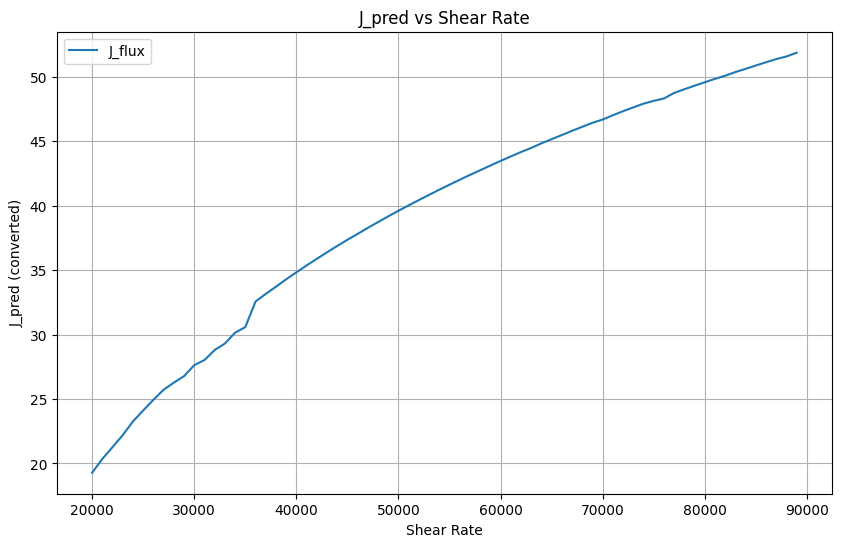

In [17]:


import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))
# plt.plot(data_figs['shear_rate'], data_figs['J_pred_10'], label='J_pred_10')
plt.plot(data_figs_2['shear_rate'], data_figs_2[['J_pred_10', 'J_pred_180', 'J_pred_300']].min(axis=1), label='J_flux')
plt.xlabel('Shear Rate')
plt.ylabel('J_pred (converted)')
plt.title('J_pred vs Shear Rate')
plt.legend()
plt.grid(True)
plt.show()


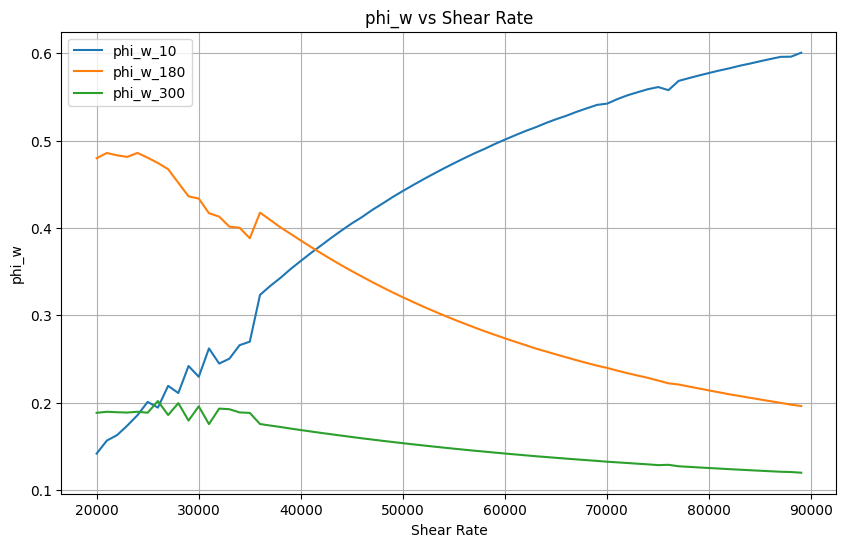

In [21]:

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(data_figs_2['shear_rate'], data_figs_2['phi_w_10'], label='phi_w_10')
plt.plot(data_figs_2['shear_rate'], data_figs_2['phi_w_180'], label='phi_w_180')
plt.plot(data_figs_2['shear_rate'], data_figs_2['phi_w_300'], label='phi_w_300')
plt.xlabel('Shear Rate')
plt.ylabel('phi_w')
plt.title('phi_w vs Shear Rate')
plt.legend()
plt.grid(True)
plt.show()

In [3]:
print(velocities_list)

[{'name': '10nm', 'radius': 1e-08, 'brownian_velocity': 1.4688509547650024e-05, 'shear_velocity': 9.395936476991296e-07, 'inertial_velocity': 2.9007820510858417e-10}, {'name': '180nm', 'radius': 1.8e-07, 'brownian_velocity': 1.3109869182209481e-06, 'shear_velocity': 2.7171005500065784e-05, 'inertial_velocity': 1.6917360921932632e-06}, {'name': '300nm', 'radius': 3e-07, 'brownian_velocity': 8.659133857149139e-07, 'shear_velocity': 4.9851623313611914e-05, 'inertial_velocity': 7.832111537931772e-06}, {'name': '10nm', 'radius': 1e-08, 'brownian_velocity': 1.4529897775571596e-05, 'shear_velocity': 9.294475799165726e-07, 'inertial_velocity': 2.9007820510858417e-10}, {'name': '180nm', 'radius': 1.8e-07, 'brownian_velocity': 7.087140501229906e-07, 'shear_velocity': 1.4688532041187212e-05, 'inertial_velocity': 1.6917360921932632e-06}, {'name': '300nm', 'radius': 3e-07, 'brownian_velocity': 2.5513969789315236e-07, 'shear_velocity': 1.4688684020304212e-05, 'inertial_velocity': 7.832111537931772e-